# Random Forest and XGBoost Classifier - Predicting Future Stock Price

## Random Forest Classifier

In [60]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [61]:
# Read in stock historical prices and calculate daily return
stock_prices = pd.read_csv("../Resources/stock_historical_prices.csv")
stock_prices = stock_prices.set_index("Date")
stock_prices.dropna(inplace=True)
stock_prices.head()

,Adj Close
Date,
2018-03-19,62.712002
2018-03-20,62.110001
2018-03-21,63.306000
2018-03-22,61.820000
2018-03-23,60.307999


In [62]:
# Drop NAs and calculate daily percent return
stock_prices['Daily_Return'] = stock_prices['Adj Close'].dropna().pct_change()
stock_prices.head()

,Adj Close,Daily_Return
Date,,
2018-03-19,62.712002,NaN
2018-03-20,62.110001,-0.009599
2018-03-21,63.306000,0.019256
2018-03-22,61.820000,-0.023473
2018-03-23,60.307999,-0.024458


In [63]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
stock_prices['Fast_Close'] = stock_prices['Adj Close'].ewm(halflife=short_window).mean()
stock_prices['Slow_Close'] = stock_prices['Adj Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
stock_prices['Crossover_Long'] = np.where(stock_prices['Fast_Close'] > stock_prices['Slow_Close'], 1.0, 0.0)
stock_prices['Crossover_Short'] = np.where(stock_prices['Fast_Close'] < stock_prices['Slow_Close'], -1.0, 0.0)
stock_prices['Crossover_Signal'] = stock_prices['Crossover_Long'] + stock_prices['Crossover_Short']

stock_prices.tail()

,Adj Close,Daily_Return,Fast_Close,Slow_Close,Crossover_Long,Crossover_Short,Crossover_Signal
Date,,,,,,,
2021-03-15,707.940002,0.020484,696.186148,715.361706,0.0,-1.0,-1.0
2021-03-16,676.880005,-0.043874,686.533076,712.784702,0.0,-1.0,-1.0
2021-03-17,701.809998,0.036831,694.171537,712.049758,0.0,-1.0,-1.0
2021-03-18,653.159973,-0.069321,673.665755,708.106086,0.0,-1.0,-1.0
2021-03-19,654.869995,0.002618,664.267875,704.541024,0.0,-1.0,-1.0


<AxesSubplot:xlabel='Date'>

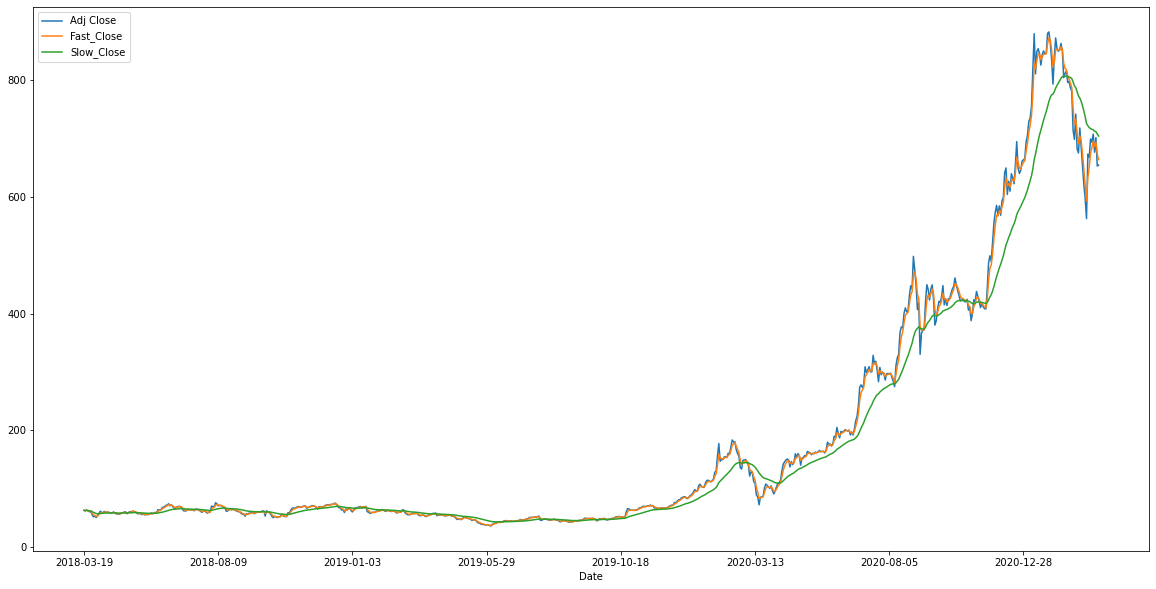

In [64]:
# Plot EMA
stock_prices[['Adj Close', 'Fast_Close', 'Slow_Close']].plot(figsize=(20,10))

In [65]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
stock_prices['Fast_Vol'] = stock_prices['Daily_Return'].ewm(halflife=short_vol_window).std()
stock_prices['Slow_Vol'] = stock_prices['Daily_Return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
stock_prices['Vol_Trend_Long'] = np.where(stock_prices['Fast_Vol'] < stock_prices['Slow_Vol'], 1.0, 0.0)
stock_prices['Vol_Trend_Short'] = np.where(stock_prices['Fast_Vol'] > stock_prices['Slow_Vol'], -1.0, 0.0) 
stock_prices['Vol_Trend_Signal'] = stock_prices['Vol_Trend_Long'] + stock_prices['Vol_Trend_Short']

stock_prices.head()

,Adj Close,Daily_Return,Fast_Close,Slow_Close,Crossover_Long,Crossover_Short,Crossover_Signal,Fast_Vol,Slow_Vol,Vol_Trend_Long,Vol_Trend_Short,Vol_Trend_Signal
Date,,,,,,,,,,,,
2018-03-19,62.712002,NaN,62.712002,62.712002,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2018-03-20,62.110001,-0.009599,62.310668,62.400573,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0
2018-03-21,63.306000,0.019256,62.879429,62.723527,1.0,0.0,1.0,0.020404,0.020404,1.0,0.0,1.0
2018-03-22,61.820000,-0.023473,62.314400,62.473646,0.0,-1.0,-1.0,0.024670,0.022066,0.0,-1.0,-1.0
2018-03-23,60.307999,-0.024458,61.278838,61.978493,0.0,-1.0,-1.0,0.018787,0.020372,1.0,0.0,1.0


<AxesSubplot:xlabel='Date'>

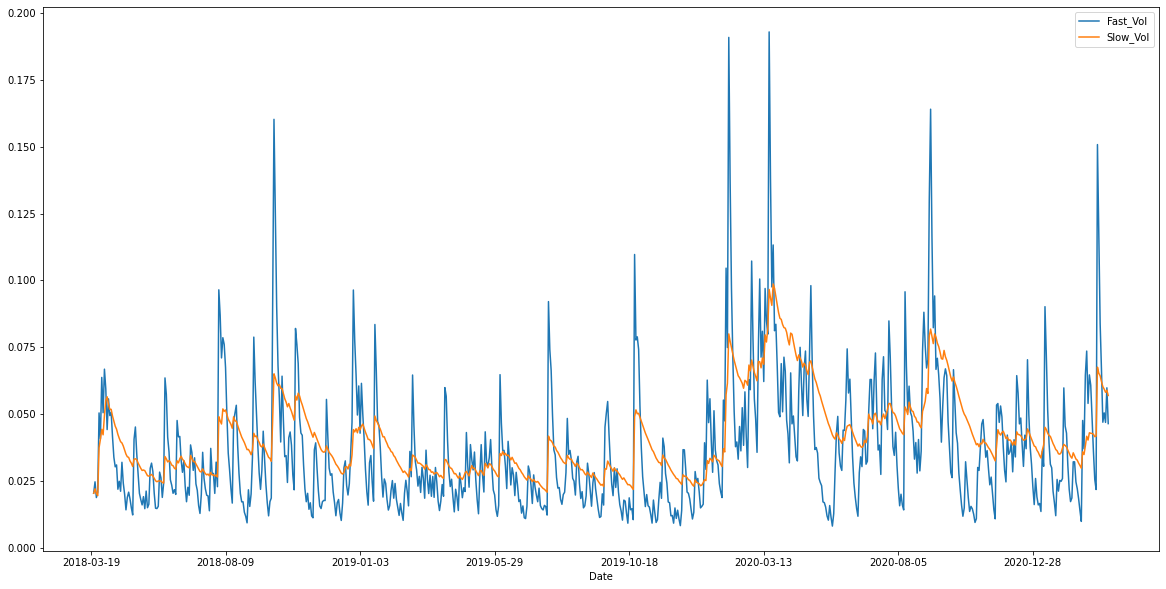

In [66]:
# Plot EMA volatility
stock_prices[['Fast_Vol', 'Slow_Vol']].plot(figsize=(20,10))

In [67]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
stock_prices['Bollinger_Mid_Band'] = stock_prices['Adj Close'].rolling(window=bollinger_window).mean()
stock_prices['Bollinger_Std'] = stock_prices['Adj Close'].rolling(window=bollinger_window).std()

# Calculate upper and lowers bands of bollinger band
stock_prices['Bollinger_Upper_Band']  = stock_prices['Bollinger_Mid_Band'] + (stock_prices['Bollinger_Std'] * 1)
stock_prices['Bollinger_Lower_Band']  = stock_prices['Bollinger_Mid_Band'] - (stock_prices['Bollinger_Std'] * 1)

# Calculate bollinger band trading signal
stock_prices['Bollinger_Long'] = np.where(stock_prices['Adj Close'] < stock_prices['Bollinger_Lower_Band'], 1.0, 0.0)
stock_prices['Bollinger_Short'] = np.where(stock_prices['Adj Close'] > stock_prices['Bollinger_Upper_Band'], -1.0, 0.0)
stock_prices['Bollinger_Signal'] = stock_prices['Bollinger_Long'] + stock_prices['Bollinger_Short']

stock_prices.head()

,Adj Close,Daily_Return,Fast_Close,Slow_Close,Crossover_Long,Crossover_Short,Crossover_Signal,Fast_Vol,Slow_Vol,Vol_Trend_Long,Vol_Trend_Short,Vol_Trend_Signal,Bollinger_Mid_Band,Bollinger_Std,Bollinger_Upper_Band,Bollinger_Lower_Band,Bollinger_Long,Bollinger_Short,Bollinger_Signal
Date,,,,,,,,,,,,,,,,,,,
2018-03-19,62.712002,NaN,62.712002,62.712002,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-03-20,62.110001,-0.009599,62.310668,62.400573,0.0,-1.0,-1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-03-21,63.306000,0.019256,62.879429,62.723527,1.0,0.0,1.0,0.020404,0.020404,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-03-22,61.820000,-0.023473,62.314400,62.473646,0.0,-1.0,-1.0,0.024670,0.022066,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2018-03-23,60.307999,-0.024458,61.278838,61.978493,0.0,-1.0,-1.0,0.018787,0.020372,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


<AxesSubplot:xlabel='Date'>

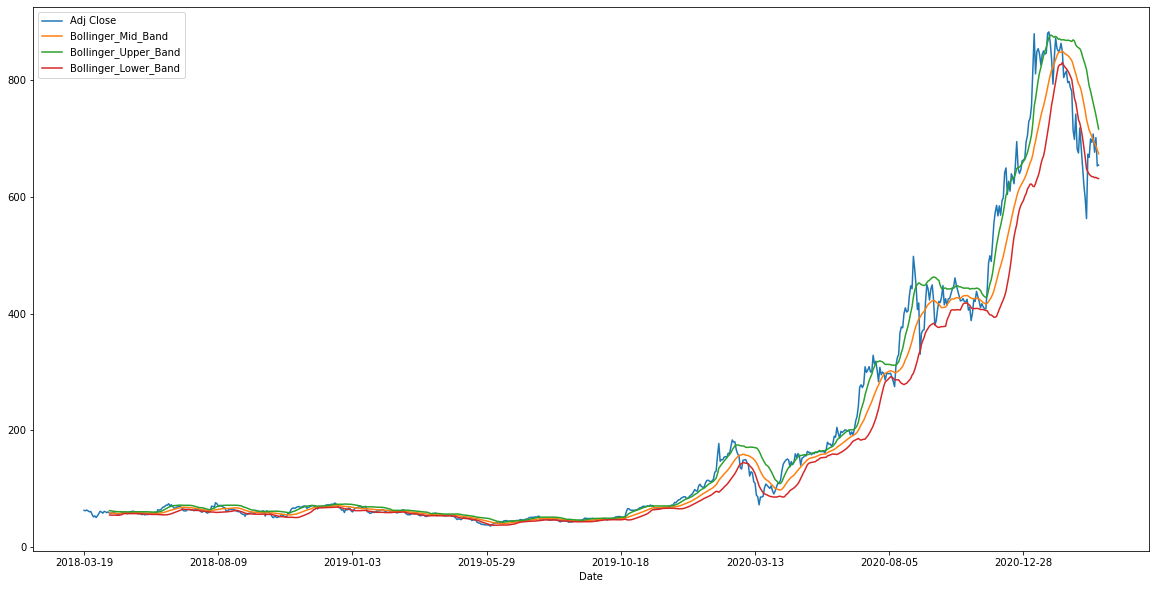

In [68]:
# Plot the Bollinger Bands for closing prices
stock_prices[['Adj Close','Bollinger_Mid_Band','Bollinger_Upper_Band','Bollinger_Lower_Band']].plot(figsize=(20,10))

In [69]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
stock_prices['Positive_Return'] = np.where(stock_prices['Daily_Return'] > 0, 1.0, 0.0)
stock_prices = stock_prices.dropna()
stock_prices.tail()

,Adj Close,Daily_Return,Fast_Close,Slow_Close,Crossover_Long,Crossover_Short,Crossover_Signal,Fast_Vol,Slow_Vol,Vol_Trend_Long,Vol_Trend_Short,Vol_Trend_Signal,Bollinger_Mid_Band,Bollinger_Std,Bollinger_Upper_Band,Bollinger_Lower_Band,Bollinger_Long,Bollinger_Short,Bollinger_Signal,Positive_Return
Date,,,,,,,,,,,,,,,,,,,,
2021-03-15,707.940002,0.020484,696.186148,715.361706,0.0,-1.0,-1.0,0.046951,0.060257,1.0,0.0,1.0,697.975000,63.177967,761.152967,634.797033,0.0,0.0,0.0,1.0
2021-03-16,676.880005,-0.043874,686.533076,712.784702,0.0,-1.0,-1.0,0.050448,0.059334,1.0,0.0,1.0,692.008002,58.901558,750.909560,633.106444,0.0,0.0,0.0,0.0
2021-03-17,701.809998,0.036831,694.171537,712.049758,0.0,-1.0,-1.0,0.046887,0.058141,1.0,0.0,1.0,687.191000,53.451580,740.642581,633.739420,0.0,0.0,0.0,1.0
2021-03-18,653.159973,-0.069321,673.665755,708.106086,0.0,-1.0,-1.0,0.059818,0.058938,0.0,-1.0,-1.0,680.479999,48.397412,728.877411,632.082587,0.0,0.0,0.0,0.0
2021-03-19,654.869995,0.002618,664.267875,704.541024,0.0,-1.0,-1.0,0.046435,0.056953,1.0,0.0,1.0,674.158499,42.423836,716.582335,631.734663,0.0,0.0,0.0,1.0


In [70]:
X = stock_prices[["Crossover_Signal","Vol_Trend_Signal","Bollinger_Signal"]]
X.tail()

,Crossover_Signal,Vol_Trend_Signal,Bollinger_Signal
Date,,,
2021-03-15,-1.0,1.0,0.0
2021-03-16,-1.0,1.0,0.0
2021-03-17,-1.0,1.0,0.0
2021-03-18,-1.0,-1.0,0.0
2021-03-19,-1.0,1.0,0.0


In [71]:
y = stock_prices["Positive_Return"]
y.tail()

Date
2021-03-15    1.0
2021-03-16    0.0
2021-03-17    1.0
2021-03-18    0.0
2021-03-19    1.0
Name: Positive_Return, dtype: float64

In [72]:
X.count()

Crossover_Signal    738
Vol_Trend_Signal    738
Bollinger_Signal    738
dtype: int64

In [73]:
y.count()

738

In [74]:
y.head()

Date
2018-04-16    0.0
2018-04-17    0.0
2018-04-18    1.0
2018-04-19    1.0
2018-04-20    0.0
Name: Positive_Return, dtype: float64

In [75]:
# Split the X and y into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

Counter(y_train)

Counter({1.0: 289, 0.0: 264})

In [76]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [77]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [78]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [79]:
# Create the decision tree classifier instance
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

# Fit the model
model = model.fit(X_train_scaled, y_train)

In [80]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [81]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [82]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,66,19
Actual 1,45,55


Accuracy Score : 0.654054054054054
Classification Report
              precision    recall  f1-score   support

         0.0       0.59      0.78      0.67        85
         1.0       0.74      0.55      0.63       100

    accuracy                           0.65       185
   macro avg       0.67      0.66      0.65       185
weighted avg       0.67      0.65      0.65       185



In [83]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results.head()

,Positive_Return,Predicted Value
Date,,
2020-12-23,1.0,0.0
2019-04-24,0.0,0.0
2020-05-18,1.0,1.0
2020-04-03,1.0,0.0
2019-12-24,1.0,1.0


# XGBoost Classifier Stock Price Prediction

In [86]:
import xgboost as xgb

In [87]:
model = xgb.XGBClassifier()
# Fit the model
model = model.fit(X_train_scaled, y_train)
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

[18:10:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/Users/draganbogatic/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [88]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [89]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,66,19
Actual 1,45,55


Accuracy Score : 0.654054054054054
Classification Report
              precision    recall  f1-score   support

         0.0       0.59      0.78      0.67        85
         1.0       0.74      0.55      0.63       100

    accuracy                           0.65       185
   macro avg       0.67      0.66      0.65       185
weighted avg       0.67      0.65      0.65       185



In [90]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results.head()

,Positive_Return,Predicted Value
Date,,
2020-12-23,1.0,0.0
2019-04-24,0.0,0.0
2020-05-18,1.0,1.0
2020-04-03,1.0,0.0
2019-12-24,1.0,1.0


In [91]:
# Both Random Forest and XGBoost Classifiers show approx. 67% overall accuracy with prediction of negative return and approx. 63% accuracy with prediction of positive return. 

# Maybe varying the length of the series and tweaking model hyperparameters will further improve model accuracy.